# Import Modules

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define physical constants

In [161]:
# Physical constants
h = 6.626e-34         # Planck constant, J·s
c = 3.0e8             # Speed of light, m/s
N_A = 6.022e23        # Avogadro's number

# Define nucleobase properties
nucleobases = ['A', 'G', 'U', 'C', 'Urea']
# Molecular weights [kg/mol]
mu = {'A': 0.135, 'G': 0.151, 'U': 0.112, 'C': 0.111, 'Urea': 0.06006}
# Solid densities [kg/m^3]
rho_solid = {'A': 1470, 'G': 2200, 'U': 1320, 'C': 1550, 'Urea': 1335}
# Stacking distance [m] #############################################33
d_stack = 6.6e-10     # ~6.6 Å

# Hydrolysis Arrhenius parameters from Supporting Info (T in K) :contentReference[oaicite:8]{index=8}
# log10(k) = -Ea/T + B  => k [s^-1]
arrhenius_params = {
    'A': {'Ea': 5902, 'B': 8.15},
    'G': {'Ea': 6330, 'B': 9.40},
    'U': {'Ea': 7649, 'B': 11.76},
    'C': {'Ea': 5620, 'B': 8.69},
    'Urea': {'Ea': 9640, 'B': 12.1}
}

# UV photodissociation parameters (dry phase) – user may adjust per scenario
F_uv = 0.4           # UV flux [W/m^2] integrated 200–250 nm (example upper limit)
lambda_uv = 225e-9   # average wavelength [m]
# Quantum efficiencies Phi for each base (molecules/photon), e.g. adenine ~1e-4
Phi_dry = {'A': 1e-4, 'G': 1e-4, 'U': 1e-4, 'C': 1e-4, 'Urea': 0}
Phi_wet = {'A': 0, 'G': 0, 'U': 0, 'C': 0, 'Urea': 1e-4}

# Seepage rate (wet phase) [m/year] from Supporting Info: 2.6 mm/day ≈ 0.95 m/y :contentReference[oaicite:9]{index=9}
S_dot = 0.95

####################
# # IDP flux per area [kg/m^2/year] for each nucleobase: user must supply or estimate
#####################

# Earth radius [m]
R_earth = 6.371e6
# Total IDP accretion rate [kg/year]
m_dot_IDP = 6e8
# Surface area [m^2]
area_earth = 4 * np.pi * R_earth**2
# Base flux [kg/m2/year]
base_flux = m_dot_IDP / area_earth  # ~1.18e-6 kg/m2/y

# Nucleobase mass fractions in IDPs (ppb -> fraction)
idp_mass_frac = {
    'A': 60.7e-9,
    'G': 141.3e-9,
    'U': 48.6e-9,
    'C': 141.3e-9,
   'Urea': 25000e-9 # CM: 10.1016/0016-7037(75)90101-5
    # upper-limit assumption
}
# Survival fraction
f_s = 1.0

# Compute idp_flux dict:
idp_flux = { base: base_flux * idp_mass_frac[base] * f_s for base in nucleobases }
# Yields approximately:
# idp_flux['A'] ~7.2e-14 kg/m2/y
# idp_flux['G'] ~1.7e-13 kg/m2/y
# idp_flux['U'] ~5.7e-14 kg/m2/y
# idp_flux['C'] ~1.7e-13 kg/m2/y


###############
# Meteorite deposition events:
###############
# A list of dicts: {'time': t0 [years], 'mass': {'A': mA, 'G': mG, ...} }
# User supplies based on external calculations (not included here)
# meteorite_events = [
#     # Example:
#     # {'time': 1.2, 'mass': {'A': 1e-6, 'G': 5e-7, 'U': 0.0, 'C': 0.0}},
# ]

# Meteoroid and pond parameters
# r = 20.0             # meteoroid radius [m]
# rho_mete = 2000.0    # kg/m3
# f_s_met = 0.32       # survival fraction
# r_g = 500.0          # strewnfield radius [m]
# rp = 1.0             # pond radius [m]
# Ap = np.pi * rp**2   # pond area

# # Nucleobase fractions
# w = {'A': 60.7e-9, 'G': 141.3e-9, 'U': 48.6e-9}
# # Compute base meteoroid volume factor
# volume_factor = (4.0/3.0) * r**3 * rho_mete * f_s_met  # = (4/3)*r^3*rho*f_s
# # Then mass in pond for each base:
# meteorite_mass_in_pond = {}
# for base in ['A','G','U']:
#     m0 = volume_factor * w[base] * (Ap / r_g**2)
#     meteorite_mass_in_pond[base] = m0
    
# meteorite_events = [
#     {
#         'time': 1.0,  # year of deposition event
#         'mass': {
#             'A': meteorite_mass_in_pond['A'],  # ~5e-6 kg
#             'G': meteorite_mass_in_pond['G'],  # ~1.2e-5 kg
#             'U': meteorite_mass_in_pond['U'],  # ~4e-6 kg
#             # 'C': 0.0  # omit or set small if desired
#         }
#     }
    
# ---- Meteorite event computation function ----
def compute_meteorite_deposition(r_meteoroid, r_g, Ap, w_met, rho_mete=2000.0, f_s_met=0.32):
    """
    Compute nucleobase mass deposited into a pond of area Ap [m^2]
    from a meteoroid of radius r_meteoroid [m], strewnfield radius r_g [m],
    nucleobase fractions w_met (dict), density rho_mete [kg/m^3], survival f_s_met.
    Returns dict {base: mass_kg}.
    """
    # Prefactor: (4/3)*r^3 * rho * f_s
    volume_factor = (4.0/3.0) * r_meteoroid**3 * rho_mete * f_s_met
    deposition = {}
    for base in ['A','G','U']:
        deposition[base] = volume_factor * w_met[base] * (Ap / r_g**2)
    # Cytosine from meteorites often neglected; set zero or small if desired
    deposition['C'] = 0.0
    return deposition

# Example pond area: radius rp = 1 m
rp = 1.0
Ap = np.pi * rp**2

# Nucleobase fractions in meteoroid (use same as IDP fractions for carbonaceous; Table S2)
w_met = {'A': 60.7e-9, 'G': 141.3e-9, 'U': 48.6e-9}

# Example 40 m diameter meteoroid => r_meteoroid = 20 m; strewnfield r_g ~500 m
r_meteoroid = 0
r_g = 500.0
meteorite_mass_example = compute_meteorite_deposition(r_meteoroid, r_g, Ap, w_met,
                                                     rho_mete=2000.0, f_s_met=0.32)
# e.g., meteorite_mass_example ~ {'A': ~5e-6, 'G': ~1.2e-5, 'U': ~4e-6, 'C': 0.0}

# ---- Define meteorite_events list ----
# For example: a single event at t = 1 year
meteorite_events = [
    {
       'time': 0.0,
       'mass': meteorite_mass_example
   }
]
# You may add further events at other times, or vary r_meteoroid, r_g per event.

# Now these idp_flux and meteorite_events can be plugged into the simulation template:

# Example printout:
print("IDP fluxes [kg/m2/year]:", idp_flux)
print("Example meteorite event masses [kg] into 1m-radius pond:", meteorite_mass_example)

IDP fluxes [kg/m2/year]: {'A': 7.140273829234937e-14, 'G': 1.6621428205451347e-13, 'U': 5.716924350919572e-14, 'C': 1.6621428205451347e-13, 'Urea': 2.940804707263154e-11}
Example meteorite event masses [kg] into 1m-radius pond: {'A': 0.0, 'G': 0.0, 'U': 0.0, 'C': 0.0}


# Define Pond and environment parameters

In [151]:
# ----- POND / ENVIRONMENT PARAMETERS -----
# Pond geometry: cylindrical pond, radius rp [m], depth max = rp [m]
rp = 1.0             # pond radius in meters (also maximum depth)
Ap = np.pi * rp**2   # pond base area [m^2]

# Environment (select one scenario, or allow as input):
# For “hot early Earth” scenario: T_C ~ 65°C; precipitation parameters from e.g. Columbia
# For “warm early Earth” scenario: T_C ~ 20°C; precipitation from e.g. Thailand
# Users should set these according to Table 1 in Pearce et al.; here we show placeholders.
T_C = 65.0           # pond temperature in °C (constant)
# Precipitation parameters (example values; replace with actual from Table 1):
P_mean = 3.0         # mean precipitation [m/year]; e.g. 3 m/y for a “wet” environment (example)
delta_p = 2.0        # dimensionless seasonal amplitude (e.g. 0–4.7 from Earth data) :contentReference[oaicite:10]{index=10}
phase_shift = 0.0    # phase shift sp in years (0 ≤ sp < 1), per latitude/location :contentReference[oaicite:11]{index=11}
# Note: Users should set P_mean, delta_p, phase_shift to match the environment they wish:
#   - “Wet” environment: high P_mean, moderate delta_p
#   - “Intermediate”: moderate P_mean
#   - “Dry”: low P_mean
#   Consult modern analogues in Table 1 of Pearce et al.

# Time parameters
t_start = 0.0   # years
t_end = 1.0    # simulate e.g. 10 years (adjust as needed)
dt = 1/365.0    # time step in years (~1 day)

# Precompute number of steps and time array
n_steps = int(np.ceil((t_end - t_start) / dt)) + 1
times = np.linspace(t_start, t_end, n_steps)

# Pre-allocate water depth array [m]
L = np.zeros(n_steps)
# Initial water depth: could start full (rp) or another initial value
L[0] = rp   # start full; users may change if desired

# Helper: temperature in Kelvin (constant here) :contentReference[oaicite:12]{index=12}
def temperature_K(t):
    """
    Return pond temperature in Kelvin at time t [years].
    Here we take constant T_C; could be extended if desired.
    """
    return T_C + 273.15

# Precompute water-depth evolution using forward Euler:
# dL/dt = 0.83 + 0.06*T_C - P_mean * [1 + delta_p * sin(2π*(t - phase_shift)/1)]
# from Eq. S23 :contentReference[oaicite:13]{index=13}
for idx in range(1, n_steps):
    t_prev = times[idx-1]
    Tcur = T_C  # constant in °C; if varying, compute from time t_prev
    # Compute precipitation term: P(t) = P_mean * [1 + delta_p * sin(2π*(t - phase_shift)/1)]
    P_t = P_mean * (1.0 + delta_p * np.sin(2*np.pi*( (t_prev - phase_shift) % 1.0 )))
    # Compute dL/dt
    dLdt = 0.83 + 0.06 * Tcur - P_t
    # Advance
    L_new = L[idx-1] + dLdt * (times[idx] - t_prev)
    # Clamp between 0 and rp
    if L_new < 0.0:
        L_new = 0.0
    elif L_new > rp:
        L_new = rp
    L[idx] = L_new

# Define is_wet based on depth threshold (e.g., > 1 mm)
def is_wet_depth(depth, threshold=1e-3):
    """
    Return True if water depth > threshold (m), indicating wet phase.
    """
    return depth > threshold

# Now prepare to simulate nucleobase mass evolution
# Precompute hydrolysis gamma factor: seconds per year
gamma = 3600 * 24 * 365.25  # s/y

# Pre-sort meteorite events by time
meteorite_events_sorted = sorted(meteorite_events, key=lambda ev: ev['time'])
event_index = 0

# Initialize mass arrays (kg) for each nucleobase
m = {base: np.zeros(n_steps) for base in nucleobases}
# Initial masses: start at zero; user may set initial non-zero
for base in nucleobases:
    m[base][0] = 0.0

# Simulation

In [153]:
# Main time-stepping loop for nucleobase mass
for idx in range(1, n_steps):
    t_prev = times[idx-1]
    t = times[idx]
    dt_step = t - t_prev

    # Current water depth and wet/dry
    L_prev = L[idx-1]
    wet = is_wet_depth(L_prev)

    # Temperature in Kelvin
    T_K = temperature_K(t_prev)
    T_C_cur = T_C  # if needed for evaporation/hydrolysis; but hydrolysis uses T_K

    # Compute hydrolysis rate constants k_i [s^-1] at current temperature
    k = {}
    for base in nucleobases:
        params = arrhenius_params[base]
        # log10(k) = -Ea/T + B
        k_s = 10**((-params['Ea'] / T_K) + params['B'])
        k[base] = k_s

    # Compute photodissociation flux per area Mdot_i [kg/m2/year] 
    # For dry phase only. This dissociates the nucleobases but not urea
    Mdot_dry = {}
    for base in nucleobases:
        Mdot_area_dry = Phi_dry[base] * F_uv * lambda_uv * gamma * mu[base] / (h * c * N_A)
        Mdot_dry[base] = Mdot_area_dry

    # Check for meteorite events between t_prev and t
    while event_index < len(meteorite_events_sorted):
        ev = meteorite_events_sorted[event_index]
        if t_prev < ev['time'] <= t + 1e-12:
            # Add mass at idx-1 step
            for base in nucleobases:
                add = ev['mass'].get(base, 0.0)
                m[base][idx-1] += add
            event_index += 1
        else:
            break

    # Update each nucleobase - sources and sinks
    for base in nucleobases:
        m_prev = m[base][idx-1]
        dm = 0.0

        # IDP source always on
        flux_idp = idp_flux.get(base, 0.0)
        if flux_idp != 0.0:
            dm += flux_idp * Ap

        if wet:
            # Hydrolysis sink: - m_prev * gamma * k[base] [kg/year]
            dm -= m_prev * gamma * k[base]
            # Seepage sink: - m_prev * (S_dot / L_prev) [kg/year], only if L_prev > 0
            if L_prev > 0:
                dm -= m_prev * (S_dot / L_prev)
            # (Meteorite diffusion-outflow sink/addition if modeling fragment release over time:
            #  not included here; user may extend with reservoir model.)
        else:
            # Dry phase: photodissociation sink
            if m_prev > 0:
                area_nucl = m_prev / (rho_solid[base] * d_stack)
            else:
                area_nucl = 0.0
            if area_nucl < Ap:
                dm -= Mdot[base] * area_nucl
            else:
                dm -= Mdot[base] * Ap
            # No hydrolysis or seepage in dry

        # Advance mass
        m_new = m_prev + dm * dt_step
        m[base][idx] = max(m_new, 0.0)

# After simulation:
# times (years), L (water depths [m]), and m[base] (mass [kg]) arrays are available.
# To compute concentration (mol/L) when wet:
#   volume V(t) = Ap * L[t] [m^3]; moles = m[base][t] / mu[base]; conc (mol/m3) = moles / V; to get mol/L divide by 1000.
# Handle dry (L->0) carefully (skip concentration or set to None).

# Example: compute concentration arrays (with NaN during dry phases)
conc = {base: np.full(n_steps, np.nan) for base in nucleobases}
for idx in range(n_steps):
    if L[idx] > 1e-6:
        V = Ap * L[idx]  # m^3
        for base in ['A','G','U']:  # Cytosine often neglected for meteorite but included if desired
            conc[base][idx] = (m[base][idx] / mu[base]) / V / 1000.0  # mol/L
    # else leave as nan

In [ ]:
# The arrays times, L, m, conc are ready for plotting or further analysis.
# Example of accessing results:
#   times in years: times
#   water depth [m]: L
#   adenine mass [kg]: m['A']
#   adenine conc [mol/L] when wet: conc['A']

# --------------------
# Users should:
# 1. Set rp, T_C, P_mean, delta_p, phase_shift to match chosen environment (hot/warm; wet/intermediate/dry).
# 2. Provide idp_flux and meteorite_events according to external estimates.
# 3. Optionally refine dt to ensure stability (e.g., smaller dt if hydrolysis or photolysis rates very fast).
# 4. Extend with fragment release reservoir if desired (e.g., use Eq. S38 for meteorite outflow dynamics).
# 5. Plot results: e.g., plot(times, conc['A']) to see adenine concentration vs time.
# 6. Validate water-depth evolution: you may print or plot L vs times to confirm seasonal cycles.

# Citations:
# - Precipitation model (sinusoidal, 1-y period) Eq. S22 :contentReference[oaicite:14]{index=14}.
# - Evaporation: dE/dt = -0.12 + 0.06*T_C [m/y]; Seepage: dS/dt = 0.95 m/y :contentReference[oaicite:15]{index=15}.
# - Net water-level change dL/dt = 0.83 + 0.06*T_C - P(...) (Eq. S23) :contentReference[oaicite:16]{index=16}.
# - Hydrolysis Arrhenius parameters Eq. S25–S28; hydrolysis sink Eq. S29 :contentReference[oaicite:17]{index=17}.
# - UV photodissociation Eq. S30–S31 :contentReference[oaicite:18]{index=18}.
# - Seepage nucleobase sink Eq. S32 :contentReference[oaicite:19]{index=19}.
# - Wet/dry switching logic as described in Nucleobase Sinks section :contentReference[oaicite:20]{index=20}.
# - Temperature choices for “hot” (~65°C) and “warm” (~20°C) early Earth analogues :contentReference[oaicite:21]{index=21}.

# Note: This code focuses solely on sources and sinks of nucleobases in a single pond,
# using the environmental functions from Pearce et al. It does not recalculate global WLP
# surface area or meteorite flux rates; those must be provided externally.

# Plotting

## Plot water depth vs time

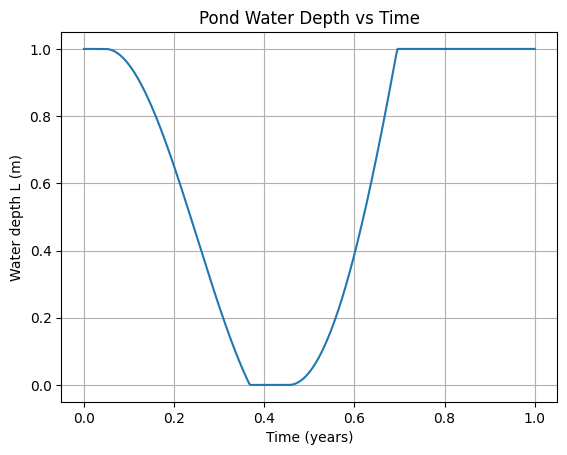

In [155]:
plt.figure()
plt.plot(times, L)
plt.xlabel('Time (years)')
plt.ylabel('Water depth L (m)')
plt.title('Pond Water Depth vs Time')
plt.grid(True)

## Plot nucleobase mass vs time

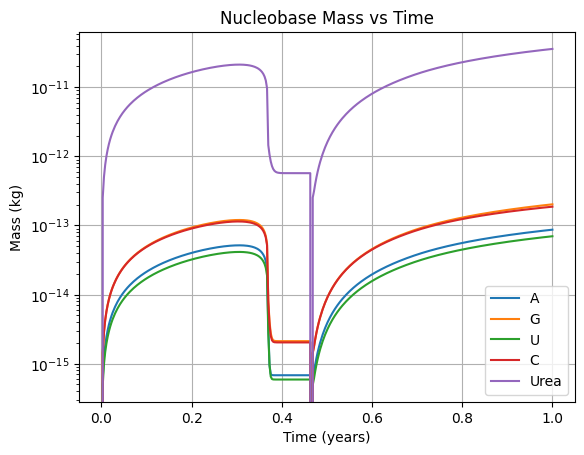

In [157]:
plt.figure()
for base in nucleobases:
    plt.plot(times, m[base], label=base)
plt.yscale("log")
plt.xlabel('Time (years)')
plt.ylabel('Mass (kg)')
plt.title('Nucleobase Mass vs Time')
plt.legend()
plt.grid(True)

## Plot concentration vs time

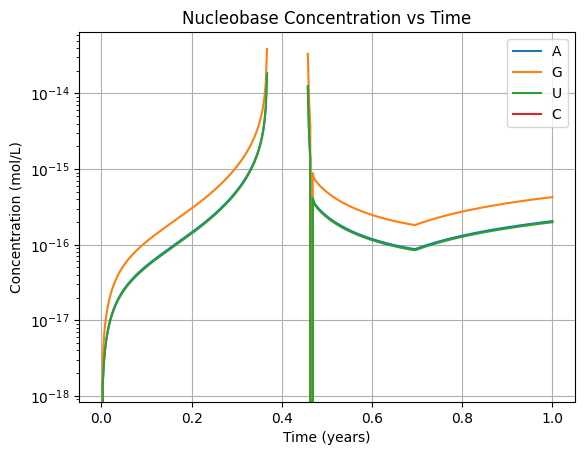

In [107]:
plt.figure()
for base in nucleobases:
    plt.plot(times, conc[base], label=base)

plt.yscale("log")
plt.xlabel('Time (years)')
plt.ylabel('Concentration (mol/L)')
plt.title('Nucleobase Concentration vs Time')
plt.legend()
plt.grid(True)

plt.show()